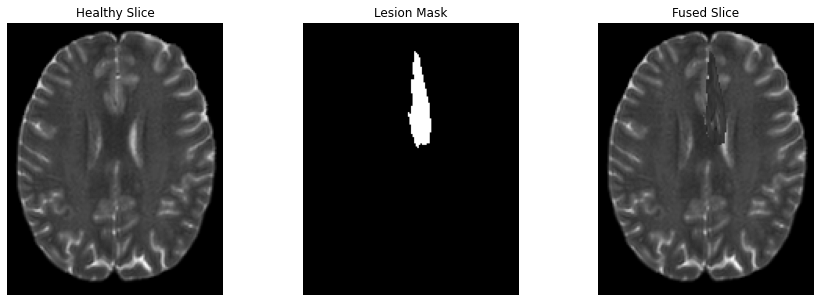

In [6]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# 定义读取2D切片的函数
def read_slice(nifti_path, slice_index):
    image = sitk.ReadImage(nifti_path)
    array = sitk.GetArrayFromImage(image)
    # 提取指定索引的切片（假设轴向方向）
    slice_2d = array[slice_index, :, :]
    return slice_2d

# 加载健康切片
healthy_img_path = './Data/Train/ixi/t2/IXI002-Guys-0828_t2.nii.gz'  # 替换为实际路径
healthy_slice_index = 90  # 根据需要选择切片索引
healthy_slice = read_slice(healthy_img_path, healthy_slice_index)

# 加载病变切片和对应的掩码
lesion_img_path = './Data/Test/Brats21/t2/BraTS2021_00000_t2.nii.gz'    # 替换为实际路径
lesion_seg_path = './Data/Test/Brats21/seg/BraTS2021_00000_seg.nii.gz'  # 替换为实际路径
lesion_slice_index = 80  # 根据需要选择切片索引
lesion_slice = read_slice(lesion_img_path, lesion_slice_index)
lesion_mask_slice = read_slice(lesion_seg_path, lesion_slice_index)

healthy_mask_path = './Data/Train/ixi/mask/IXI002-Guys-0828_mask.nii.gz'
mask_slice_index = 90
mask_slice = read_slice(healthy_mask_path, mask_slice_index)
# 数据预处理
def preprocess_slice(slice_2d):
    # 将像素值归一化到 [0, 1]
    slice_2d = (slice_2d - np.min(slice_2d)) / (np.max(slice_2d) - np.min(slice_2d))
    return slice_2d

healthy_slice = preprocess_slice(healthy_slice)
lesion_slice = preprocess_slice(lesion_slice)
lesion_mask_slice = preprocess_slice(lesion_mask_slice)
lesion_mask_slice = (lesion_mask_slice > 0).astype(np.uint8)  # 将掩码二值化

# 如果尺寸不同，调整到相同尺寸
if healthy_slice.shape != lesion_slice.shape:
    target_size = healthy_slice.shape
    lesion_slice = sitk.GetArrayFromImage(
        sitk.Resample(
            sitk.GetImageFromArray(lesion_slice),
            sitk.GetImageFromArray(healthy_slice),
            sitk.Transform(),
            sitk.sitkLinear
        )
    )
    lesion_mask_slice = sitk.GetArrayFromImage(
        sitk.Resample(
            sitk.GetImageFromArray(lesion_mask_slice),
            sitk.GetImageFromArray(healthy_slice),
            sitk.Transform(),
            sitk.sitkNearestNeighbor
        )
    )

# 将2D切片转换为 SimpleITK 图像
def array_to_sitk(slice_2d):
    image = sitk.GetImageFromArray(slice_2d)
    image.SetSpacing((1.0, 1.0))  # 设置像素间距
    return image

healthy_sitk = array_to_sitk(healthy_slice)
lesion_sitk = array_to_sitk(lesion_slice)
lesion_mask_sitk = array_to_sitk(lesion_mask_slice)

# 图像配准
def register_2d_images(fixed_image, moving_image):
    # 初始变换
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.AffineTransform(2),  # 2D仿射变换
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    # 配准方法设置
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=1e-6,
        numberOfIterations=100,
        gradientMagnitudeTolerance=1e-8
    )
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    # 执行配准
    final_transform = registration_method.Execute(fixed_image, moving_image)
    return final_transform

transform = register_2d_images(healthy_sitk, lesion_sitk)

# 应用变换到病变切片和掩码
lesion_sitk_registered = sitk.Resample(lesion_sitk, healthy_sitk, transform, sitk.sitkLinear, 0.0, lesion_sitk.GetPixelID())
lesion_mask_sitk_registered = sitk.Resample(lesion_mask_sitk, healthy_sitk, transform, sitk.sitkNearestNeighbor, 0.0, lesion_mask_sitk.GetPixelID())

# 转换回 numpy 数组
lesion_slice_registered = sitk.GetArrayFromImage(lesion_sitk_registered)
lesion_mask_registered = sitk.GetArrayFromImage(lesion_mask_sitk_registered)

# 融合病变区域到健康切片
fused_slice = healthy_slice.copy()
valid_mask = (lesion_mask_registered > 0) & (mask_slice > 0)
fused_slice[valid_mask] = lesion_slice_registered[valid_mask]

# 可视化结果
def show_images(images, titles):
    num_images = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

show_images(
    [healthy_slice, lesion_mask_registered, fused_slice],
    ['Healthy Slice', 'Lesion Mask', 'Fused Slice']
)